In [1]:
#pip install pyspark

In [2]:
#conda install -c cyclus java-jdk

In [3]:
#pip install py4j

In [4]:
#load pySpark modules 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import *
from pyspark.sql.functions import *
import time
spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "30g") \
    .config('spark.executor.memory=30g')\
    .appName('final') \
    .getOrCreate()
sc=spark.sparkContext

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/06 12:26:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/05/06 12:26:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [5]:
#load flight data file into pySpark dataFrame format

flight = spark.read.csv("flights.csv", inferSchema=True, header=True)
airports = spark.read.csv("airports.csv", inferSchema=True, header=True)
flight.show(5)
airports.show(5)


+----------+---------+-------+---------------+-------------+--------+--------+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|ArrDelay|
+----------+---------+-------+---------------+-------------+--------+--------+
|        19|        5|     DL|          11433|        13303|      -3|       1|
|        19|        5|     DL|          14869|        12478|       0|      -8|
|        19|        5|     DL|          14057|        14869|      -4|     -15|
|        19|        5|     DL|          15016|        11433|      28|      24|
|        19|        5|     DL|          11193|        12892|      -6|     -11|
+----------+---------+-------+---------------+-------------+--------+--------+
only showing top 5 rows

+----------+-----------+-----+--------------------+
|airport_id|       city|state|                name|
+----------+-----------+-----+--------------------+
|     10165|Adak Island|   AK|                Adak|
|     10299|  Anchorage|   AK|Ted Stevens Ancho...|
|   

In [6]:
df_dis = flight.distinct()
df_f = df_dis.select('DayofMonth','DayOfWeek','Carrier','OriginAirportID','DestAirportID','DepDelay',((col("ArrDelay") > 15).cast("Int").alias("label")))
df_f = df_f.withColumnRenamed("label", "trueLabel")
df_f.show(5)

+----------+---------+-------+---------------+-------------+--------+---------+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|trueLabel|
+----------+---------+-------+---------------+-------------+--------+---------+
|         6|        1|     WN|          10821|        10140|       1|        0|
|         8|        1|     AA|          11298|        10140|       0|        0|
|        15|        1|     WN|          14747|        10140|      -6|        0|
|        27|        1|     AA|          11298|        10140|     113|        1|
|         7|        2|     OO|          12266|        10140|      -3|        0|
+----------+---------+-------+---------------+-------------+--------+---------+
only showing top 5 rows



### Define the Pipeline and split the data 

In [24]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, MinMaxScaler
strIdx = StringIndexer(inputCol = "Carrier", outputCol = "CarrierIdx")
catVect = VectorAssembler(inputCols = ["CarrierIdx", "DayofMonth", "DayOfWeek", "OriginAirportID", "DestAirportID"], outputCol="catFeatures")
catIdx = VectorIndexer(inputCol = catVect.getOutputCol(), outputCol = "idxCatFeatures")
numVect = VectorAssembler(inputCols = ["DepDelay"], outputCol="numFeatures")
minMax = MinMaxScaler(inputCol = numVect.getOutputCol(), outputCol="normFeatures")
featVect = VectorAssembler(inputCols=["idxCatFeatures", "normFeatures"], outputCol="features")
label_stringIdx = StringIndexer(inputCol = 'trueLabel', outputCol = 'label')
train, test = df_f.randomSplit([0.8, 0.2], seed = 2018)


### build the RandomForestClassifier model

In [25]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')

pipeline = Pipeline(stages=[strIdx, catVect, catIdx, numVect, minMax, featVect,label_stringIdx, rf])
#train the model
t1 = time.time()
rfmodel = pipeline.fit(train)
t2 = time.time()
print(t2-t1)

22/05/06 16:58:01 WARN MemoryStore: Not enough space to cache rdd_1799_2 in memory! (computed 18.5 MiB so far)
22/05/06 16:58:01 WARN BlockManager: Persisting block rdd_1799_2 to disk instead.
22/05/06 16:58:01 WARN MemoryStore: Not enough space to cache rdd_1799_3 in memory! (computed 18.5 MiB so far)
22/05/06 16:58:01 WARN BlockManager: Persisting block rdd_1799_3 to disk instead.
22/05/06 16:58:02 WARN MemoryStore: Not enough space to cache rdd_1799_1 in memory! (computed 42.7 MiB so far)
22/05/06 16:58:02 WARN BlockManager: Persisting block rdd_1799_1 to disk instead.
22/05/06 16:58:03 WARN MemoryStore: Not enough space to cache rdd_1799_0 in memory! (computed 42.7 MiB so far)
22/05/06 16:58:03 WARN BlockManager: Persisting block rdd_1799_0 to disk instead.
22/05/06 16:58:09 WARN MemoryStore: Not enough space to cache rdd_1799_2 in memory! (computed 96.2 MiB so far)
22/05/06 16:58:09 WARN MemoryStore: Not enough space to cache rdd_1799_3 in memory! (computed 64.1 MiB so far)
22/05/

107.06662011146545


#### Make predictions on the test set

In [26]:
predictions = rfmodel.transform(test)
predictions_rf = predictions.select("features", 'label',"prediction", "trueLabel")
predictions_rf.show(5)
#predictions.show(5)

+--------------------+-----+----------+---------+
|            features|label|prediction|trueLabel|
+--------------------+-----+----------+---------+
|[10.0,1.0,0.0,103...|  0.0|       0.0|        0|
|[10.0,1.0,0.0,104...|  0.0|       0.0|        0|
|[10.0,1.0,0.0,107...|  0.0|       0.0|        0|
|[10.0,1.0,0.0,107...|  1.0|       0.0|        1|
|[10.0,1.0,0.0,107...|  0.0|       0.0|        0|
+--------------------+-----+----------+---------+
only showing top 5 rows



#### Evaluate our  model.

In [27]:
#Evaluating prediction results

tp = float(predictions.filter("prediction == 1.0 AND label == 1").count())
fp = float(predictions.filter("prediction == 1.0 AND label == 0").count())
tn = float(predictions.filter("prediction == 0.0 AND label == 0").count())
fn = float(predictions.filter("prediction == 0.0 AND label == 1").count())
pr = tp / (tp + fp)
re = tp / (tp + fn)
metrics = spark.createDataFrame([
 ("TP", tp),
 ("FP", fp),
 ("TN", tn),
 ("FN", fn),
 ("Precision", pr),
 ("Recall", re),
 ("F1", 2*pr*re/(re+pr))],["metric", "value"])
metrics.show()

+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|           75942.0|
|       FP|            8267.0|
|       TN|          423188.0|
|       FN|           31448.0|
|Precision|0.9018275956251707|
|   Recall|0.7071608157184095|
|       F1|0.7927181248336368|
+---------+------------------+



In [28]:
#Evaluate our Logistic Regression model.
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8989897047300137


In [29]:
from sklearn import metrics
actual =predictions.select('label').toPandas()
predicted = predictions.select('prediction').toPandas()
accuracy = metrics.accuracy_score(actual, predicted)
print('accuracy = ', accuracy)

accuracy =  0.9262960591635814


/var/folders/gw/yh0lqvkx31988_00fxgrp7680000gn/T/ipykernel_13933/123946932.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,1], [0,1], 'k--', color='orange')


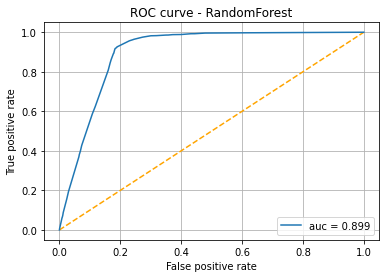

In [13]:
import numpy as np
import matplotlib.pyplot as plt
pred_pd_full = predictions.select(['label', 'prediction', 'probability']).toPandas()
pred_pd_full['probability'] = pred_pd_full['probability'].map(lambda x: list(x))
pred_pd_full['encoded_label'] = pred_pd_full['label'].map(lambda x: np.eye(2)[int(x)])

y_pred = np.array(pred_pd_full['probability'].tolist())
y_true = np.array(pred_pd_full['encoded_label'].tolist())
from sklearn.metrics import auc, roc_curve
fpr, tpr, threshold = roc_curve(y_score=y_pred[:,0], y_true=y_true[:,0])
auc = auc(fpr, tpr)


plt.plot([0,1], [0,1], 'k--', color='orange')
plt.plot(fpr, tpr, label='auc = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RandomForest')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [30]:
train5, test5 = df_f.randomSplit([0.5, 0.5], seed = 2000)
train6, test6 = df_f.randomSplit([0.5, 0.5], seed = 2001)
train7, test7 = df_f.randomSplit([0.5, 0.5], seed = 2002)
train9, test9 = df_f.randomSplit([0.5, 0.5], seed = 2003)

In [31]:
#train the model
t1 = time.time()
rfmodel = pipeline.fit(train5)
t2 = time.time()
print(t2-t1)
#predict the model
predictions5 = rfmodel.transform(test5)
#evaluate the model
tp = float(predictions5.filter("prediction == 1.0 AND label == 1").count())
fp = float(predictions5.filter("prediction == 1.0 AND label == 0").count())
tn = float(predictions5.filter("prediction == 0.0 AND label == 0").count())
fn = float(predictions5.filter("prediction == 0.0 AND label == 1").count())
pr = tp / (tp + fp)
re = tp / (tp + fn)
metrics = spark.createDataFrame([
 ("TP", tp),
 ("FP", fp),
 ("TN", tn),
 ("FN", fn),
 ("Precision", pr),
 ("Recall", re),
 ("F1", 2*pr*re/(re+pr))],["metric", "value"])
metrics.show()
#evaluate AUC
evaluator = BinaryClassificationEvaluator(labelCol="trueLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
print('AUC = ', evaluator.evaluate(predictions5))


22/05/06 17:01:00 WARN MemoryStore: Not enough space to cache rdd_2000_1 in memory! (computed 18.5 MiB so far)
22/05/06 17:01:00 WARN BlockManager: Persisting block rdd_2000_1 to disk instead.
22/05/06 17:01:00 WARN MemoryStore: Not enough space to cache rdd_2000_3 in memory! (computed 18.5 MiB so far)
22/05/06 17:01:00 WARN BlockManager: Persisting block rdd_2000_3 to disk instead.
22/05/06 17:01:02 WARN MemoryStore: Not enough space to cache rdd_2000_0 in memory! (computed 42.7 MiB so far)
22/05/06 17:01:02 WARN BlockManager: Persisting block rdd_2000_0 to disk instead.
22/05/06 17:01:02 WARN MemoryStore: Not enough space to cache rdd_2000_2 in memory! (computed 42.7 MiB so far)
22/05/06 17:01:02 WARN BlockManager: Persisting block rdd_2000_2 to disk instead.


78.11148023605347


+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|          186654.0|
|       FP|           17615.0|
|       TN|         1061872.0|
|       FN|           82104.0|
|Precision|0.9137656717367785|
|   Recall|0.6945058379657536|
|       F1|0.7891896234253014|
+---------+------------------+



AUC =  0.8982416262702655


In [32]:
#train the model
t1 = time.time()
rfmodel = pipeline.fit(train6)
t2 = time.time()
print(t2-t1)
#predict the model
predictions6 = rfmodel.transform(test6)
#evaluate the model
tp = float(predictions6.filter("prediction == 1.0 AND label == 1").count())
fp = float(predictions6.filter("prediction == 1.0 AND label == 0").count())
tn = float(predictions6.filter("prediction == 0.0 AND label == 0").count())
fn = float(predictions6.filter("prediction == 0.0 AND label == 1").count())
pr = tp / (tp + fp)
re = tp / (tp + fn)
metrics = spark.createDataFrame([
 ("TP", tp),
 ("FP", fp),
 ("TN", tn),
 ("FN", fn),
 ("Precision", pr),
 ("Recall", re),
 ("F1", 2*pr*re/(re+pr))],["metric", "value"])
metrics.show()
#evaluate AUC
evaluator = BinaryClassificationEvaluator(labelCol="trueLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
print('AUC = ', evaluator.evaluate(predictions6))


22/05/06 17:03:39 WARN MemoryStore: Not enough space to cache rdd_2180_0 in memory! (computed 18.5 MiB so far)
22/05/06 17:03:39 WARN BlockManager: Persisting block rdd_2180_0 to disk instead.
22/05/06 17:03:39 WARN MemoryStore: Not enough space to cache rdd_2180_1 in memory! (computed 28.5 MiB so far)
22/05/06 17:03:39 WARN BlockManager: Persisting block rdd_2180_1 to disk instead.
22/05/06 17:03:39 WARN MemoryStore: Not enough space to cache rdd_2180_3 in memory! (computed 18.5 MiB so far)
22/05/06 17:03:39 WARN BlockManager: Persisting block rdd_2180_3 to disk instead.


100.74328088760376


+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|          190892.0|
|       FP|           20817.0|
|       TN|         1058055.0|
|       FN|           78558.0|
|Precision|0.9016716341771016|
|   Recall|0.7084505474113936|
|       F1|0.7934674400769808|
+---------+------------------+



AUC =  0.9019860075783623


In [33]:
#train the model
t1 = time.time()
rfmodel = pipeline.fit(train7)
t2 = time.time()
print(t2-t1)
#predict the model
predictions7 = rfmodel.transform(test7)
#evaluate the model
tp = float(predictions7.filter("prediction == 1.0 AND label == 1").count())
fp = float(predictions7.filter("prediction == 1.0 AND label == 0").count())
tn = float(predictions7.filter("prediction == 0.0 AND label == 0").count())
fn = float(predictions7.filter("prediction == 0.0 AND label == 1").count())
pr = tp / (tp + fp)
re = tp / (tp + fn)
metrics = spark.createDataFrame([
 ("TP", tp),
 ("FP", fp),
 ("TN", tn),
 ("FN", fn),
 ("Precision", pr),
 ("Recall", re),
 ("F1", 2*pr*re/(re+pr))],["metric", "value"])
metrics.show()
#evaluate AUC
evaluator = BinaryClassificationEvaluator(labelCol="trueLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
print('AUC = ', evaluator.evaluate(predictions7))

22/05/06 17:05:58 WARN MemoryStore: Not enough space to cache rdd_2360_2 in memory! (computed 18.5 MiB so far)
22/05/06 17:05:58 WARN BlockManager: Persisting block rdd_2360_2 to disk instead.
22/05/06 17:05:58 WARN MemoryStore: Not enough space to cache rdd_2360_3 in memory! (computed 18.5 MiB so far)
22/05/06 17:05:58 WARN BlockManager: Persisting block rdd_2360_3 to disk instead.
22/05/06 17:05:59 WARN MemoryStore: Not enough space to cache rdd_2360_0 in memory! (computed 42.7 MiB so far)
22/05/06 17:05:59 WARN BlockManager: Persisting block rdd_2360_0 to disk instead.
22/05/06 17:05:59 WARN MemoryStore: Not enough space to cache rdd_2360_1 in memory! (computed 42.7 MiB so far)
22/05/06 17:05:59 WARN BlockManager: Persisting block rdd_2360_1 to disk instead.


78.74678206443787


+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|          194240.0|
|       FP|           24558.0|
|       TN|         1054943.0|
|       FN|           74413.0|
|Precision|0.8877594859185185|
|   Recall|0.7230144461442828|
|       F1|0.7969621561962126|
+---------+------------------+



AUC =  0.9026620188075808


In [34]:
#train the model
t1 = time.time()
rfmodel = pipeline.fit(train9)
t2 = time.time()
print(t2-t1)
#predict the model
predictions9 = rfmodel.transform(test9)
#evaluate the model
tp = float(predictions9.filter("prediction == 1.0 AND label == 1").count())
fp = float(predictions9.filter("prediction == 1.0 AND label == 0").count())
tn = float(predictions9.filter("prediction == 0.0 AND label == 0").count())
fn = float(predictions9.filter("prediction == 0.0 AND label == 1").count())
pr = tp / (tp + fp)
re = tp / (tp + fn)
metrics = spark.createDataFrame([
 ("TP", tp),
 ("FP", fp),
 ("TN", tn),
 ("FN", fn),
 ("Precision", pr),
 ("Recall", re),
 ("F1", 2*pr*re/(re+pr))],["metric", "value"])
metrics.show()
#evaluate AUC
evaluator = BinaryClassificationEvaluator(labelCol="trueLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
print('AUC = ', evaluator.evaluate(predictions9))

22/05/06 17:08:12 WARN MemoryStore: Not enough space to cache rdd_2540_3 in memory! (computed 18.5 MiB so far)
22/05/06 17:08:12 WARN BlockManager: Persisting block rdd_2540_3 to disk instead.
22/05/06 17:08:12 WARN MemoryStore: Not enough space to cache rdd_2540_2 in memory! (computed 18.5 MiB so far)
22/05/06 17:08:12 WARN BlockManager: Persisting block rdd_2540_2 to disk instead.
22/05/06 17:08:13 WARN MemoryStore: Not enough space to cache rdd_2540_1 in memory! (computed 42.7 MiB so far)
22/05/06 17:08:13 WARN BlockManager: Persisting block rdd_2540_1 to disk instead.
22/05/06 17:08:14 WARN MemoryStore: Not enough space to cache rdd_2540_0 in memory! (computed 42.7 MiB so far)
22/05/06 17:08:14 WARN BlockManager: Persisting block rdd_2540_0 to disk instead.


76.2203917503357


+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|          190398.0|
|       FP|           21006.0|
|       TN|         1058617.0|
|       FN|           78166.0|
|Precision| 0.900635749560084|
|   Recall|0.7089483326134552|
|       F1|0.7933778918594573|
+---------+------------------+



AUC =  0.8996417976572527


In [35]:
from sklearn import metrics
actual5 =predictions5.select('label').toPandas()
predicted5 = predictions5.select('prediction').toPandas()
accuracy5 = metrics.accuracy_score(actual5, predicted5)
print('accuracy = ', accuracy5)

accuracy =  0.9260379233744609


In [36]:
#evaluate accuracy
actual6 =predictions6.select('label').toPandas()
predicted6 = predictions6.select('prediction').toPandas()
accuracy6= metrics.accuracy_score(actual6, predicted6)
print('accuracy6 = ', accuracy6)

accuracy6 =  0.9262972791365861


In [37]:
#evaluate accuracy
actual7 =predictions7.select('label').toPandas()
predicted7 = predictions7.select('prediction').toPandas()
accuracy7 = metrics.accuracy_score(actual7, predicted7)
print('accuracy7 = ', accuracy7)

accuracy7 =  0.9265877637124542


In [38]:
#evaluate accuracy
actual9 =predictions9.select('label').toPandas()
predicted9 = predictions9.select('prediction').toPandas()
accuracy9 = metrics.accuracy_score(actual9, predicted9)
print('accuracy9 = ', accuracy9)

accuracy9 =  0.9264404715369604


In [ ]:
#sc.stop()